# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

from IPython.display import Image

import pickle

import time
import warnings

# Tempo de processamento
time_agora = time.time()

###### 0.1 Helper Functions

In [2]:
# Função buscar outlier pelo método do 6 Sigma
def buscar_outlier(df, series):
    média = df[series].mean()
    desvio_padrão = df[series].std()
    lis = média - (desvio_padrão * 3)
    lss = média + (desvio_padrão * 3)
    lista_outliers = df[(df[series] < lis) | (df[series] > lss)].index
    return lista_outliers, lis, lss

###### 0.3 Loading Dataset

In [3]:
df = pd.read_csv(r'D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\train.csv')

test = df.sample(frac=0.1)
test_indices = test.index
df = df.drop(test_indices)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0


# 1.0 Data Description

### 1.1 Data Dimensions

In [4]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 342998
Number of columns: 12


### 1.2 Data Types

In [5]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

### 1.3 Check Na

In [6]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### 1.4 Descriptive Statistical

###### 1.4.1 Classifying Attributes

In [7]:
features_categóricas = ['Gender', 'Vehicle_Damage', 'Vehicle_Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']
features_numéricas = ['Age', 'Annual_Premium']

###### 1.4.2 Target

In [8]:
print(f'A porcentagem de interessados no produto é: {round(df["Response"].mean(), 2) * 100} %')

A porcentagem de interessados no produto é: 12.0 %


Desbalanceada

###### 1.4.3 Numerical Features

In [9]:
# Central tendency
ct1 = pd.DataFrame(df[features_numéricas].apply(np.mean)).T
ct2 = pd.DataFrame(df[features_numéricas].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[features_numéricas].apply(np.std)).T
d2 = pd.DataFrame(df[features_numéricas].apply(min)).T
d3 = pd.DataFrame(df[features_numéricas].apply(max)).T
d4 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
Age,20.0,85.0,65.0,38.829142,36.0,15.516217,0.672356,-0.565053
Annual_Premium,2630.0,540165.0,537535.0,30563.066196,31664.5,17200.645334,1.747635,33.524176


* Range de idade entre 20 e 85 anos, sem indícios de erros de inputs
* Annual_Premium com possíveis outliers

In [10]:
df[features_numéricas].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,342998.0,38.829142,15.516240,20.0,25.0,36.0,49.0,85.0
Annual_Premium,342998.0,30563.066196,17200.670408,2630.0,24412.0,31664.5,39398.0,540165.0


* Idade com média e mediana próximas, dados centralizados na média, skew baixa, o que reforça distribuição centralizada na média, skew pouco positiva, o que sugere cauda esquerda mais pesada, kurtosis baixa e negativa, o que sugere uma distribuição um pouco mais plana em relação a uma normal com mesma média e desvio padrão, uma distribuição próxima a uma NORMAL
* Prêmio Anual com média e mediana próximos, o que sugere dados centralizados na média, skew baixa e positiva, o que sugere dados centralizados na média com uma cauda esquerda mais pesada, kurtosis bastante alto, o que sugere um pico bastante elevado, uma distribuição próxima a uma POISSON

###### 1.4.4 Categorical Features

In [11]:
df[features_categóricas].astype('category').describe().T

,count,unique,top,freq
Gender,342998,2,Male,185298
Vehicle_Damage,342998,2,Yes,173133
Vehicle_Age,342998,3,1-2 Year,180294
Driving_License,342998,2,1,342258
Region_Code,342998.0,53.0,28.0,95775.0
Previously_Insured,342998,2,0,185717
Policy_Sales_Channel,342998.0,152.0,152.0,121327.0
Vintage,342998,290,256,1286


* Sexo relativamente balanceado com a maioria de mulheres
* Maior parte dos clientes possuem veículos com menos de 1 ano
* Maior parte dos clientes já teve danos em seu veículo
* Habilitação para dirigir balanceado
* Há 53 regiões diferentes e por volta de 30% dos clientes estão contidos na região 28
* Um pouco mais que 50% dos clientes não possuem seguro veicular
* Há 157 canais de vendas, e por volta de 35% dos clientes estão contidos no canal 152.

# 3.0 Feature Engineering

### 3.1 Business Hypothesis

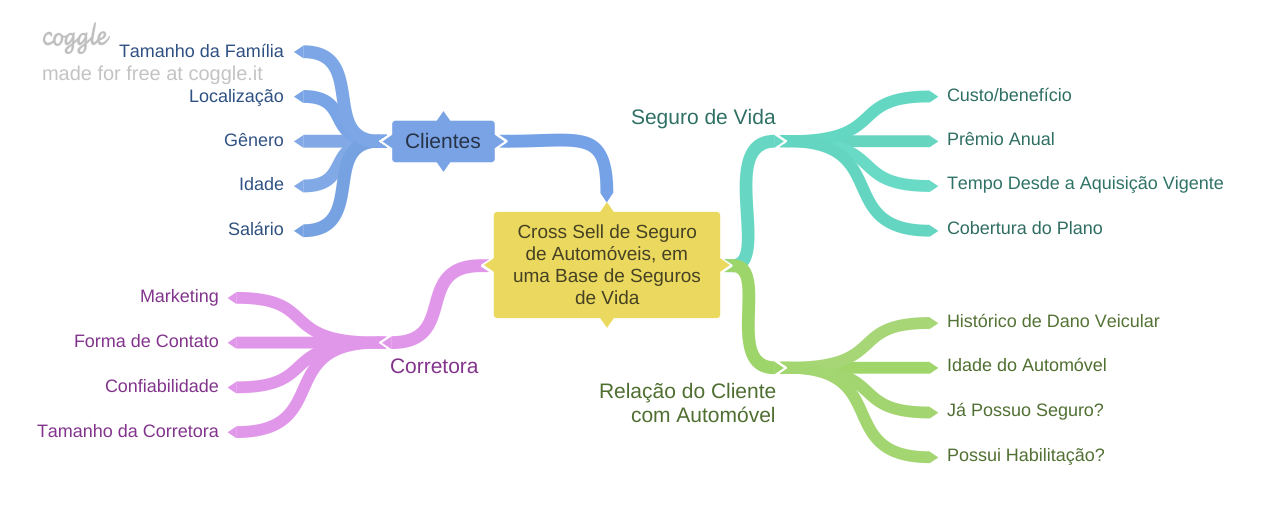

In [12]:
Image('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\img\\mindmap.JPG')

### 3.2 Creating Hypothesis

###### Corretora:
* Contatos mais diretos com os clientes deveriam gerar mais vendas
* Ações de marketing deveriam gerar mais vendas.
* Contato mais próximo com o cliente deveriam gerar mais vendas
* Maior confiabilidade da parte da corretora deveria gerar mais vendas.

###### Clientes:
* Clientes localizados em regiões com maiores rendas percaptas deveriam comprar mais
* Clientes do gênero feminino deveriam comprar mais
* Clientes mais velhos deveriam comprar mais
* Clientes com famílias maiores deveriam comprar mais

###### Seguro de Vida:
* Contas de Seguro de Vida com valores mais altos deveriam gerar mais vendas
* Contas com tempo de aquisição vigente maior deveriam gerar mais vendas

###### Relação do Cliente com o Automóvel:
* Clientes que já acionaram o seguro no passado deveriam comprar mais
* Clientes com veículos mais novos deveriam comprar mais
* Clientes que não possuem seguro de automóvel deveriam comprara mais.
* Clientes habilitados deveriam comprar mais.

###### Hipóteses Selecionadas:
1. ...
2. ...

### 3.3 Creating Features

### 3.4 Encoding Features

In [13]:
# gender
le_gender = LabelEncoder().fit(df['Gender'])
df['le_gender'] = le_gender.transform(df['Gender'])

# vehicle_damage
le_vehicle_damage = LabelEncoder().fit(df['Vehicle_Damage'])
df['le_vehicle_damage'] = le_vehicle_damage.transform(df['Vehicle_Damage'])

# vehicle_age
le_vehicle_age = LabelEncoder().fit(df['Vehicle_Age'])
df['le_vehicle_age'] = le_vehicle_age.transform(df['Vehicle_Age'])

# 5.0 Exploratory Data Analysis

## Principais Insights:

### Espaço Amostral
1. 6 dimensões parecem explicar 90% de toda variabilidade das features
2. Annual_Premium transformada por log apresenta uma shape semelhante a uma normal
3. 4 features binárias, 2 numéricas, 1 categórica e 2 categóricas com excessivas categorias e portanto foram transformadas em numéricas.

### Features Analysis

###### Response:
1. Desbalanceada com 12% de eventos positivos
2. Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

###### Gender:
1. Balanceada
2. Correlações muito fracas
3. Homens se interessam 30% mais no produto em relação às mulheres

###### Vehicle_Age:
1. Mais da metade dos clientes possuem carros com menos de 1 ano
2. Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel
3. Médias de response bastante distintas

###### Vehicle_Damage:
1. Balanceada
2. Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age
3. Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### Driving_License:
1. Correlações muito fracas
2. 99% dos clientes são habilitados
3. Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### Previously_Insured:
1. 45% dos clientes já possuem seguro veicular
2. Clientes que já possuem seguro têm interesse quase zero pelo produto
3. Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

###### Region_Code:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
3. A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
4. As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
5. Médias de response bastante distintas, com desvios padrões baixos

###### Policy_Sales_Channel:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
2. 5 categorias contém 84.19% do total de clientes
3. Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured
4. Médias de response por canais de Policy_Sales_Channel bastante distintas
5. Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Vintage:
1. Feature categórica, há 290 categorias em Vintage

###### Age:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input
2. Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
3. Sem outliers
4. A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
5. Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
6. Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage
7. Clientes com menos de 30 anos de idade apresentam em média 4% de interesse no produto, enquanto os clientes com 30 anos ou mais têm em média 17% interesse no produto.


###### Annual_Premium
1. 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
2. Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
3. Acima do terceiro quartil da distribuição há um interesse relativo 20% maior no produto

## 5.2 Univariate Analysis

#### Response

In [14]:
df['Response'].mean()

0.12240596155079621

In [15]:
df.corr()['Response'].sort_values(ascending=False)[1:]

le_vehicle_damage       0.354200
Age                     0.111319
le_gender               0.051982
Annual_Premium          0.022813
Driving_License         0.011231
Region_Code             0.010695
Vintage                -0.000579
id                     -0.001474
le_vehicle_age         -0.104035
Policy_Sales_Channel   -0.139260
Previously_Insured     -0.341066
Name: Response, dtype: float64

Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

#### Gender

In [16]:
df.corr()['le_gender'].sort_values(ascending=False)[1:]

Age                     0.145858
le_vehicle_damage       0.091242
Response                0.051982
Annual_Premium          0.002912
Region_Code             0.000716
id                      0.000669
Vintage                -0.003180
Driving_License        -0.018437
Previously_Insured     -0.081853
Policy_Sales_Channel   -0.111191
le_vehicle_age         -0.113284
Name: le_gender, dtype: float64

Correlações muito fracas

In [17]:
le_gender.inverse_transform([0])

array(['Female'], dtype=object)

In [18]:
print(f'{round(df.loc[df["le_gender"]==0, "Response"].mean() *100, 2)}% das mulheres se interessam pelo produto.')
print(f'{round(df.loc[df["le_gender"]==1, "Response"].mean() *100, 2)}% dos homens se interessam pelo produto.')

10.39% das mulheres se interessam pelo produto.
13.81% dos homens se interessam pelo produto.


#### Age

In [19]:
df.corr()['Age'].sort_values(ascending=False)[1:]

le_vehicle_damage       0.268080
le_gender               0.145858
Response                0.111319
Annual_Premium          0.066275
Region_Code             0.042285
id                      0.000932
Vintage                -0.001669
Driving_License        -0.081012
Previously_Insured     -0.255586
le_vehicle_age         -0.522592
Policy_Sales_Channel   -0.578417
Name: Age, dtype: float64

Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

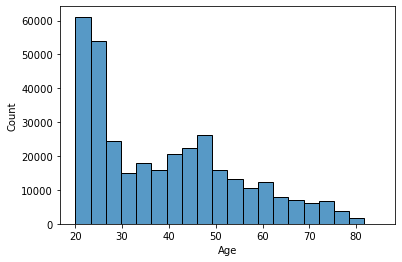

In [20]:
sns.histplot(df['Age'], bins=20);

Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.

In [21]:
índices, li, ls = buscar_outlier(df, 'Age')

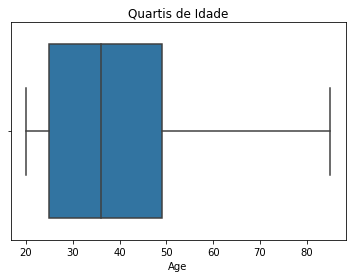

In [22]:
sns.boxplot(data=df, x='Age')
plt.title('Quartis de Idade');

sem outliers

In [23]:
print(f'A média de idade entre os que NÃO se interessam pelo produto: {round(df.loc[df["Response"]==0, "Age"].mean(), 2)}%')
print(f'A média de idade entre os que se interessam pelo produto: {round(df.loc[df["Response"]==1, "Age"].mean(), 2)}%')

A média de idade entre os que NÃO se interessam pelo produto: 38.18%
A média de idade entre os que se interessam pelo produto: 43.45%


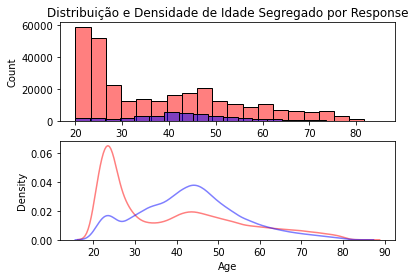

In [24]:
plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Idade Segregado por Response')
g = sns.histplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5, bins=20)
g = sns.histplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)

Pessoas mais velhas apresentam maior interesse no produto

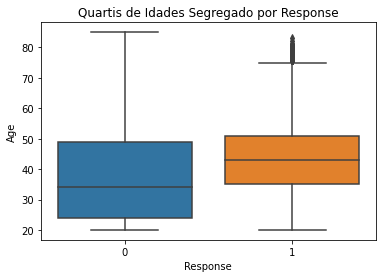

In [25]:
sns.boxplot(x='Response', y='Age', data=df)
plt.title('Quartis de Idades Segregado por Response');

Pessoas mais velhas apresentam interesse maior pelo produto

#### Driving_License

In [26]:
df.corr()['Driving_License'].sort_values(ascending=False)[1:]

Policy_Sales_Channel    0.043907
le_vehicle_age          0.031881
Previously_Insured      0.015552
Response                0.011231
Vintage                -0.000432
Region_Code            -0.000525
id                     -0.001219
Annual_Premium         -0.012439
le_vehicle_damage      -0.017152
le_gender              -0.018437
Age                    -0.081012
Name: Driving_License, dtype: float64

Correlações muito fracas

In [27]:
print(f'{round(df["Driving_License"].mean(), 3)}% dos clientes são habilitados')

0.998% dos clientes são habilitados


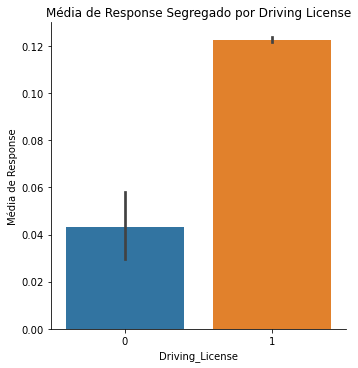

In [28]:
sns.catplot(x='Driving_License', y= 'Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Driving License');

In [29]:
print(f'Habilitados tem: {round(df.loc[df["Driving_License"]==0, "Response"].mean()*100, 2)}% de interesse no produto')
print(f'NÃO habilitados tem: {round(df.loc[df["Driving_License"]==1, "Response"].mean()*100, 2)}% de interesse no produto')

Habilitados tem: 4.32% de interesse no produto
NÃO habilitados tem: 12.26% de interesse no produto


#### Previously_Insured

In [30]:
df.corr()['Previously_Insured'].sort_values(ascending=False)[1:]

Policy_Sales_Channel    0.219499
le_vehicle_age          0.175092
Driving_License         0.015552
Annual_Premium          0.005069
id                      0.002594
Vintage                 0.002077
Region_Code            -0.024936
le_gender              -0.081853
Age                    -0.255586
Response               -0.341066
le_vehicle_damage      -0.824136
Name: Previously_Insured, dtype: float64

Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

In [31]:
df['Previously_Insured'].mean()

0.45854786325284697

45% dos clientes já sofreram danos veiculares

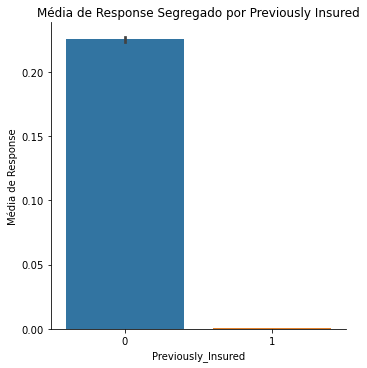

In [32]:
sns.catplot(x='Previously_Insured', y='Response', data=df, kind='bar')
plt.title('Média de Response Segregado por Previously Insured')
plt.ylabel('Média de Response');

In [33]:
df.loc[df['Previously_Insured']==1, 'Response'].mean()*100

0.09346329181528602

Clientes que possuem seguro veicular tem interesse quase zero no produto

#### Region_Code

In [34]:
df.corr()['Region_Code'].sort_values(ascending=False)[1:]

Age                     0.042285
le_vehicle_damage       0.028846
Response                0.010695
le_gender               0.000716
id                      0.000272
Driving_License        -0.000525
Vintage                -0.002792
Annual_Premium         -0.010354
Previously_Insured     -0.024936
le_vehicle_age         -0.027528
Policy_Sales_Channel   -0.042567
Name: Region_Code, dtype: float64

Correlações muito fracas

In [35]:
df['Region_Code'].nunique()

53

53 categorias

In [36]:
df['Region_Code'].value_counts(normalize=True).head(5)

28.0    0.279229
8.0     0.088852
46.0    0.051872
41.0    0.047852
15.0    0.034887
Name: Region_Code, dtype: float64

In [37]:
df['Region_Code'].value_counts(normalize=True).tail(5)

1.0     0.002656
44.0    0.002149
42.0    0.001536
52.0    0.000703
51.0    0.000493
Name: Region_Code, dtype: float64

In [38]:
df['Region_Code'].value_counts(normalize=True).head(5).sum()

0.502690977789958

28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais densas.

In [39]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).head(5)

,Region_Code,Response
38,38.0,0.193760
28,28.0,0.187011
19,19.0,0.161244
4,4.0,0.156116
23,23.0,0.149687


In [40]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).tail(5)

,Region_Code,Response
22,22.0,0.065034
50,50.0,0.063580
10,10.0,0.060204
25,25.0,0.042895
44,44.0,0.042062


As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%

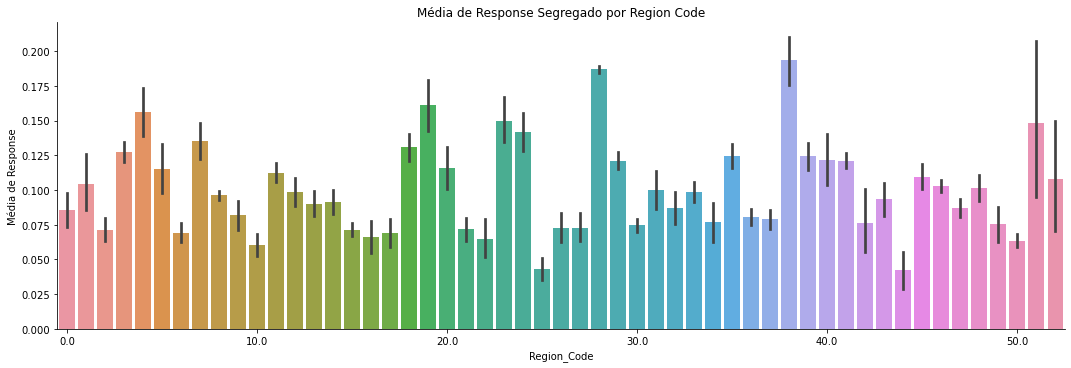

In [41]:
sns.catplot(x='Region_Code', y='Response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Region Code')
plt.xticks(range(0, int(df['Region_Code'].max()), 10))
plt.ylabel('Média de Response');

Médias de response bastante distintas, com desvios padrões baixos

#### Vehicle_Age

In [42]:
df.corr()['le_vehicle_age'].sort_values(ascending=False)[1:]

Policy_Sales_Channel    0.388394
Previously_Insured      0.175092
Driving_License         0.031881
Annual_Premium          0.024327
Vintage                 0.002926
id                     -0.001338
Region_Code            -0.027528
Response               -0.104035
le_gender              -0.113284
le_vehicle_damage      -0.174366
Age                    -0.522592
Name: le_vehicle_age, dtype: float64

Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel

In [43]:
df['Vehicle_Age'].value_counts(normalize=True)

1-2 Year     0.525642
< 1 Year     0.432352
> 2 Years    0.042006
Name: Vehicle_Age, dtype: float64

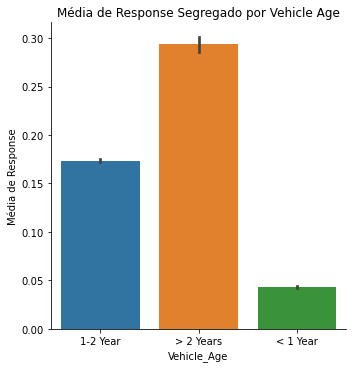

In [44]:
sns.catplot(x='Vehicle_Age', y='Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Vehicle Age');

Médias de response bastante distintas

#### Vehicle_Damage

In [45]:
df.corr()['le_vehicle_damage'].sort_values(ascending=False)[1:]

Response                0.354200
Age                     0.268080
le_gender               0.091242
Region_Code             0.028846
Annual_Premium          0.008255
Vintage                -0.000952
id                     -0.001366
Driving_License        -0.017152
le_vehicle_age         -0.174366
Policy_Sales_Channel   -0.224470
Previously_Insured     -0.824136
Name: le_vehicle_damage, dtype: float64

Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age

In [46]:
df['Vehicle_Damage'].value_counts(normalize=True)

Yes    0.504764
No     0.495236
Name: Vehicle_Damage, dtype: float64

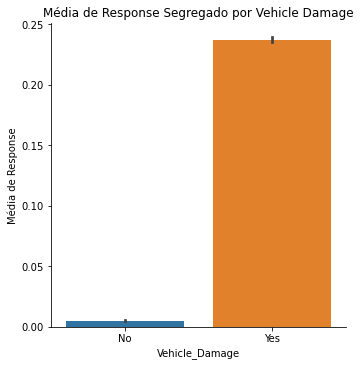

In [47]:
sns.catplot(x='Vehicle_Damage', y='Response', data=df, kind='bar')
plt.title('Média de Response Segregado por Vehicle Damage')
plt.ylabel('Média de Response');

In [48]:
print(f'Clientes que já tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="Yes", "Response"].mean()*100, 2)}% de response')
print(f'Clientes que NÃO tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="No", "Response"].mean()*100, 2)}% de response')

Clientes que já tiveram danos tem: 23.74% de response
Clientes que NÃO tiveram danos tem: 0.52% de response


Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

#### Annual_Premium

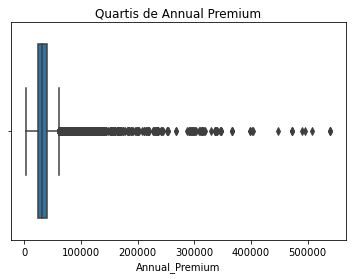

In [49]:
sns.boxplot(x='Annual_Premium', data=df)
plt.title('Quartis de Annual Premium');

Muitos outliers

In [50]:
índices, li, ls = buscar_outlier(df, 'Annual_Premium')

print(f'Há {len(índices)} outliers no total')

Há 1868 outliers no total


In [51]:
df.corr()['Annual_Premium'].sort_values(ascending=False)[1:]

Age                     0.066275
le_vehicle_age          0.024327
Response                0.022813
le_vehicle_damage       0.008255
Previously_Insured      0.005069
le_gender               0.002912
id                      0.002060
Vintage                -0.000993
Region_Code            -0.010354
Driving_License        -0.012439
Policy_Sales_Channel   -0.112058
Name: Annual_Premium, dtype: float64

Correlações muito fracas

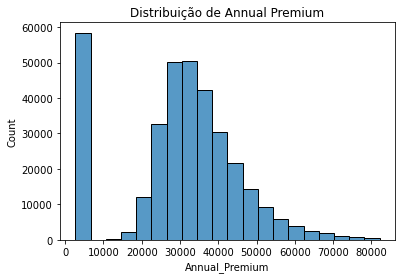

In [52]:
sns.histplot(df.drop(índices)['Annual_Premium'], bins=20)
plt.title('Distribuição de Annual Premium');

In [53]:
df['Annual_Premium'].value_counts(normalize=True).head(5)

2630.0     0.170188
69856.0    0.000376
39008.0    0.000111
38287.0    0.000105
38452.0    0.000099
Name: Annual_Premium, dtype: float64

17% dos clientes estão contidos em um valor discreto de 2630 dollares. Um estudo separadamente para este grupo pode ser interessante.

In [54]:
print(f'A média de interesse no produto do grupo de clientes com valor FIXO de seguro: {round(df.loc[df["Annual_Premium"]==2630, "Response"].mean()*100, 2)}%')
print(f'A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: {round(df.loc[df["Annual_Premium"]!=2630, "Response"].mean()*100, 2)}%')

A média de interesse no produto do grupo de clientes com valor FIXO de seguro: 13.08%
A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: 12.07%


O interesse no produto não é significativamente diferente entre os dois grupos de clientes

Para uma melhor visualização, os dados serão filtrados provisioriamente até 100000 dollares

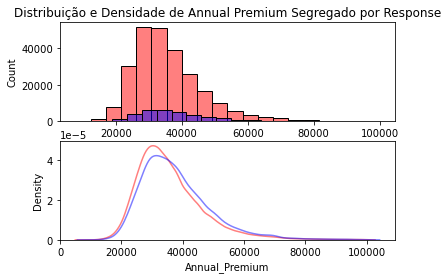

In [55]:
temp = df.loc[(df['Annual_Premium']>2630)&(df['Annual_Premium']<100000)]

plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Annual Premium Segregado por Response')
g = sns.histplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5, bins=20)
g = sns.histplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5)

Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

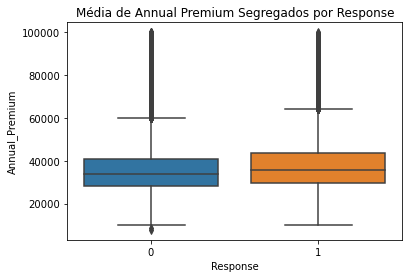

In [56]:
plt.title('Média de Annual Premium Segregados por Response')
sns.boxplot(x='Response', y='Annual_Premium', data=temp);

Sem diferença significativa

#### Policy_Sales_Channel

In [57]:
df.corr()['Policy_Sales_Channel'].sort_values(ascending=False)[1:]

le_vehicle_age        0.388394
Previously_Insured    0.219499
Driving_License       0.043907
Vintage               0.000509
id                   -0.002009
Region_Code          -0.042567
le_gender            -0.111191
Annual_Premium       -0.112058
Response             -0.139260
le_vehicle_damage    -0.224470
Age                  -0.578417
Name: Policy_Sales_Channel, dtype: float64

Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured

In [58]:
df['Policy_Sales_Channel'].value_counts(normalize=True).head(5)

152.0    0.353725
26.0     0.208931
124.0    0.194258
160.0    0.057204
156.0    0.027989
Name: Policy_Sales_Channel, dtype: float64

In [59]:
canais_mais_utilizados = df['Policy_Sales_Channel'].value_counts(normalize=True).head(5).index

In [60]:
print(f'5 categorias contém {round(df["Policy_Sales_Channel"].value_counts(normalize=True).head(5).sum()*100, 2)}% do total de clientes')

5 categorias contém 84.21% do total de clientes


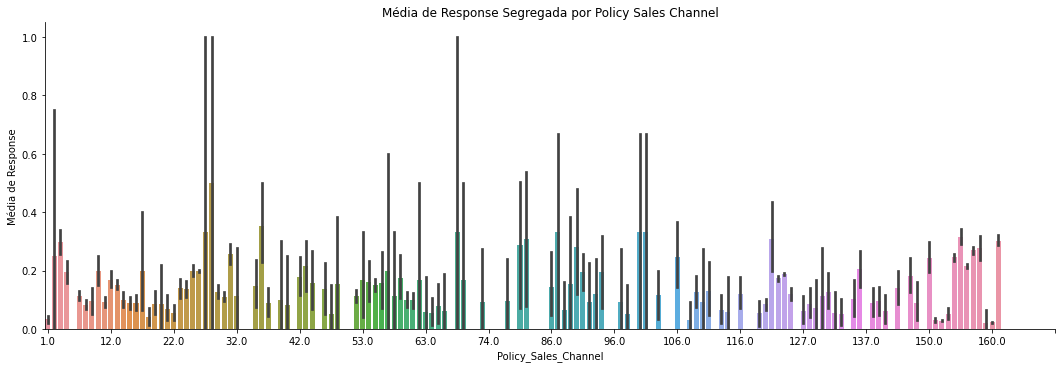

In [61]:
sns.catplot(x='Policy_Sales_Channel', y='Response', data=df, kind='bar', aspect=3)
plt.xticks(range(0, int(df['Policy_Sales_Channel'].max()), 10))
plt.title('Média de Response Segregada por Policy Sales Channel')
plt.ylabel('Média de Response');

Médias de response por canais de Policy_Sales_Channel bastante distintas

In [62]:
temp = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'count'})
temp.rename(columns={'Response':'Response_Count'}, inplace=True)

temp2 = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'mean'})
temp2.rename(columns={'Response':'Response_Mean'}, inplace=True)

temp3 = temp.merge(temp2, how='left', on='Policy_Sales_Channel')
temp3.sort_values('Response_Count', ascending=False).head(5)

,Policy_Sales_Channel,Response_Count,Response_Mean
142,152.0,121327,0.028444
24,26.0,71663,0.199182
117,124.0,66630,0.189224
150,160.0,19621,0.022170
146,156.0,9600,0.215208


Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

#### Vintage

In [63]:
df.corr()['Vintage'].sort_values(ascending=False)[1:]

le_vehicle_age          0.002926
Previously_Insured      0.002077
Policy_Sales_Channel    0.000509
Driving_License        -0.000432
Response               -0.000579
id                     -0.000908
le_vehicle_damage      -0.000952
Annual_Premium         -0.000993
Age                    -0.001669
Region_Code            -0.002792
le_gender              -0.003180
Name: Vintage, dtype: float64

Correlações muito fracas

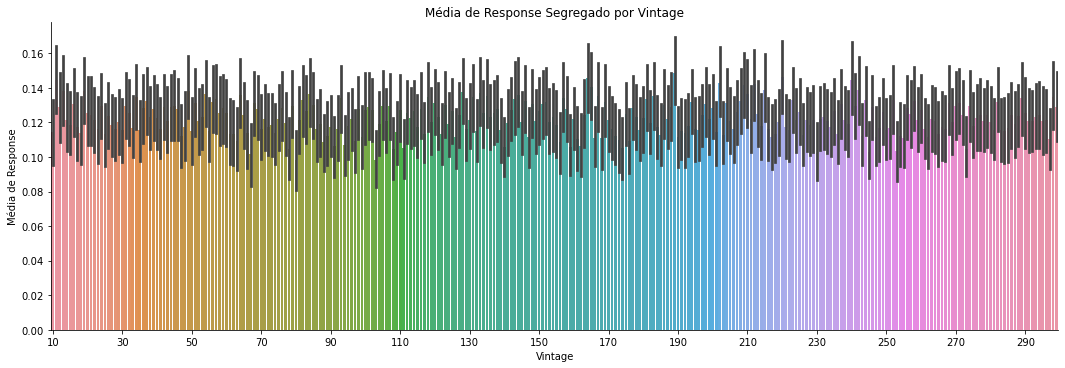

In [64]:
sns.catplot(x='Vintage', y='Response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Vintage')
plt.ylabel('Média de Response')
plt.xticks(range(0, df['Vintage'].max(), 20));

Muito ruidoso, os desvios padrões colocam tudo no mesmo nível.

## 5.3 Bivariate Analysis

## 5.4 Multivariate Analysis

# 6.0 Exportings

In [65]:
# test
pickle.dump(test, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\test.pkl', 'wb'))

# dataframe
pickle.dump(df, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\interim\\df_to_data_preparation.pkl', 'wb'))

# encodings
pickle.dump(le_gender, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\le_gender.pkl', 'wb'))
pickle.dump(le_vehicle_damage, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\le_vehicle_damage.pkl', 'wb'))
pickle.dump(le_vehicle_age, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\le_vehicle_age.pkl', 'wb'))

# Time

In [66]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
